# Introduction
In Part I, we collected data for S&P 500 for analysis. In Part II, we perform ARIMA Modelling on the data.

### Overview
1. Load dataset and libraries
2. Prepare data via upsampling and backfilling
3. Identify the p, d, and q terms for our ARIMA model through statistical and visual methods
4. Train an ARIMA model
5. Compare the model predictions and actual test data

A short summary of ARIMA Modelling is in ```ARIMA_MODELLING.md```.

### Quick intro to ARIMA
Auto Regressive Integrated Moving Average, or ARIMA for short, is a forecasting model for time-series data. 

ARIMA is composed of three components:
1. AR - AutoRegression
2. I - Integrated
3. MA - Moving Average

The ARIMA model models three aspects of a time series: seasonality (how cyclical pattern is), trend (which direction is the plot moving towards over time), and noise (how much random variability there is in the data). 

These aspects are represented by the parameters <em>p</em>, <em>d</em>, and <em>q</em>.

- p: number of non-regressive terms (for AR)
- d: number of non-seasonable differences (for I)
- q: number of moving average terms (for MA)

Ideally, we must transform our time series such that it remains stationary, i.e. hover around 0. Removing trends and seasonality makes modelling easier and more accurate.

More readings:
- <strong>General reading</strong>: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7 (use Incognito if you don't have a Medium account)
- <strong>For differencing/I term</strong>: https://people.duke.edu/~rnau/411arim2.htm
- <strong>For AR and MA terms</strong>: https://people.duke.edu/~rnau/411arim3.htm.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the S&P 500 CSV as DataFrame
df = pd.read_csv('spx.csv', index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


### Plot the DataFrame's 'Open'
We now visualize the open price for S&P 500 using matplotlib.pyplot.

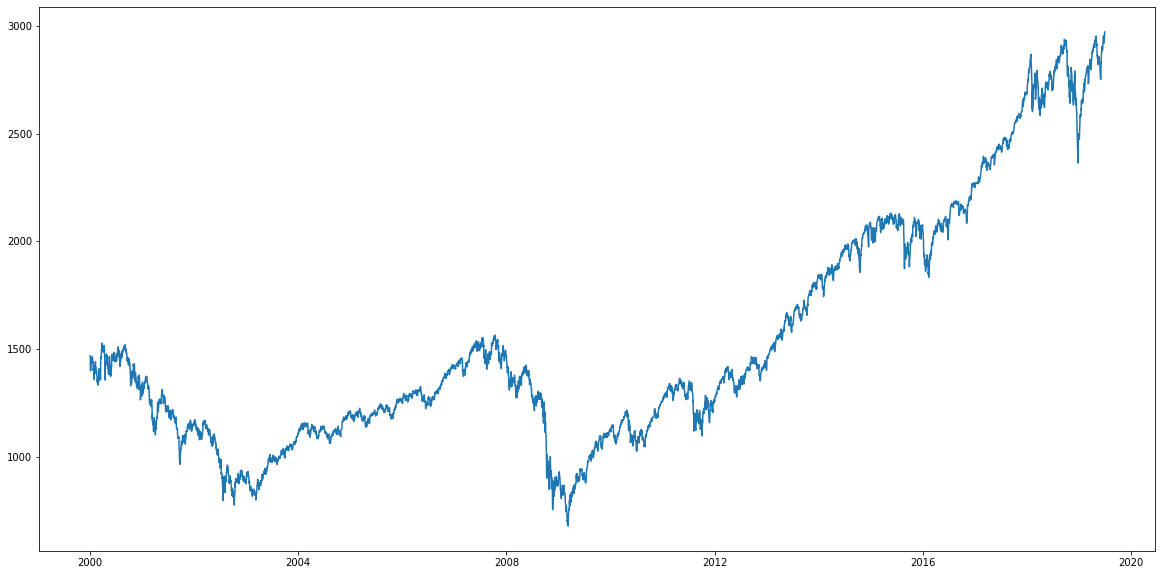

In [3]:
# Plot 'Open'
plt.figure(figsize=(20,10))
plt.plot(df['Open'])

## Data preparation

### Fill in the missing dates
We now prepare our dataset for ARIMA modelling. Our current dataset does not have continuous dates in the index because the prices are only available on weekdays. 

To fill in missing dates, we will use the .asfreq method and pass through the 'D' frequency into it, along with an interpolate method to fill the missing values in other columns.

We <strong>backfill</strong> and not interpolate because the prices from Friday remain the same throughout the weekend and changes only on Monday.

In [4]:
df_filled = df.asfreq('D', method='ffill')
df_filled["2000-01-04":"2000-01-11"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
2000-01-08,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
2000-01-09,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000
2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000


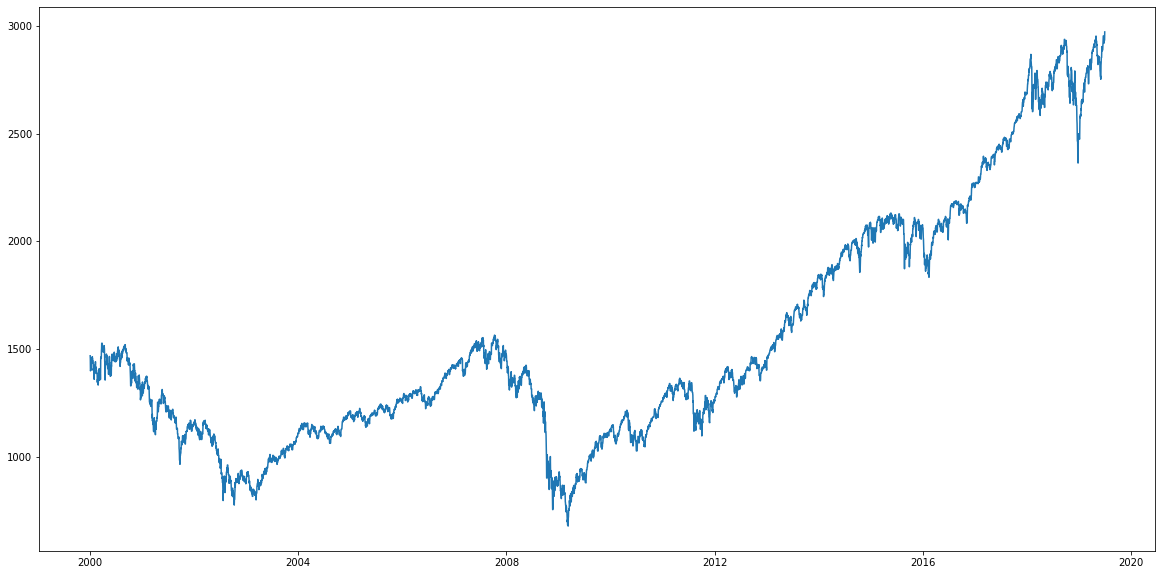

In [5]:
# Plot 'Open' from the new DataFrame
plt.figure(figsize=(20,10))
plt.plot(df_filled['Open'])

### Differencing

We now obtain the d term, which is the number of differencing required to turn the plot stationary.

In [6]:
df_filled['first_diff'] = df_filled['Open'].diff()
df_filled = df_filled.dropna()
df_filled.head()

,Open,High,Low,Close,Adj Close,Volume,first_diff
Date,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-14.030029
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-55.799927
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,2.689941
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1.339966
2000-01-08,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.000000


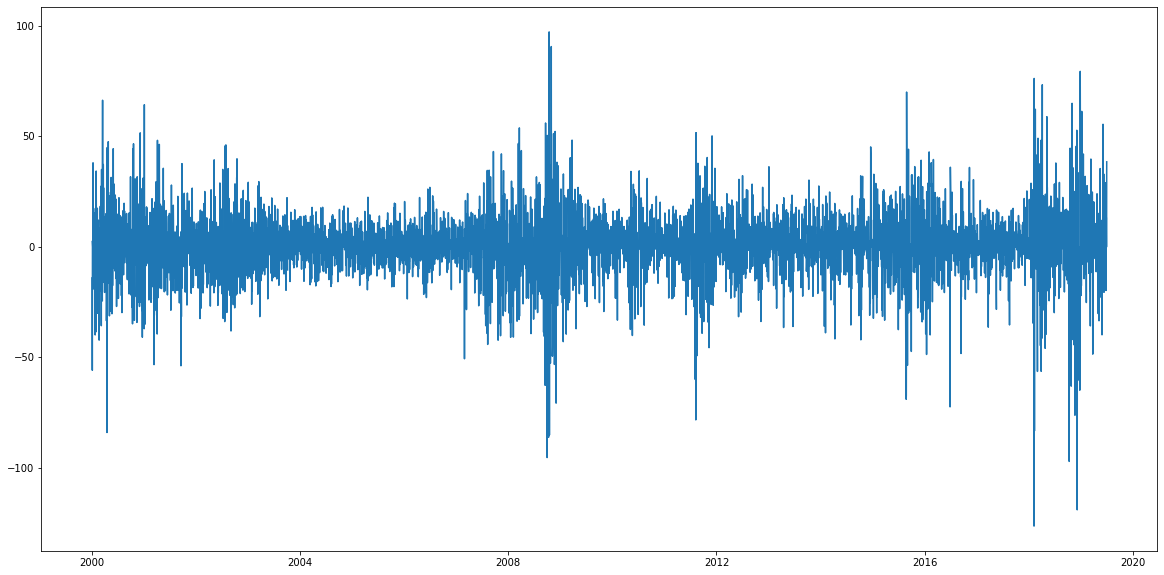

In [7]:
# Plot first_diff
plt.figure(figsize=(20,10))
plt.plot(df_filled['first_diff'])

### Use Augmented Dickey Fuller Test to test for stationary nature
Visually, it looks like the plot of first_diff is stationary. 

We use a statistical test called Augmented Dickey Fuller Test to verify statistically.

The null hypothesis is that the plot is not stationary. The alternative hypothesis is that the plot is stationary. 

When we conduct the test, and the p-value is less than 0.05, we can reject the null hypothesis, i.e. the time series is stationary.

In [8]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

In [9]:
# Use adfuller on 'first_df'
adfuller(df_filled['first_diff'])

(-19.439816690716118,
 0.0,
 20,
 7098,
 {'1%': -3.43127162108596,
  '5%': -2.861947283361622,
  '10%': -2.5669867928635224},
 56206.391034663684)

The p-value is 0.0, hence we reject the null hypothesis and accept the alternative that the plot is indeed stationary.

We conclude that d = 1.

## Determining the numbers for AR (p) and MA (q) terms
The ACF plots the coefficients of correlation between a time series and lags of itself in a bar chart. 

The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

We will use the ACF plot to find the MA (q) term and PACF plot to find the AR (p) term.

In [10]:
# Import the libraries you need
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Plot PACF of first_diff data
We'll plot the PACF using first_diff, and look for the first x-value that is under the cut-off 0.05 cutoff.

That value will be our AR (p) term. 

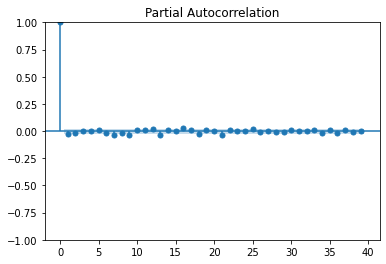

In [11]:
# Plot PACF of first_diff
plot_pacf(df_filled['first_diff'],method="ywm")
plt.show()

### Plot ACF of first_diff data
After plotting PACF, we will then plot the ACF of the first_diff values to get our MA term (q).

Similarly, we look for the first x-value that falls within the blue box.

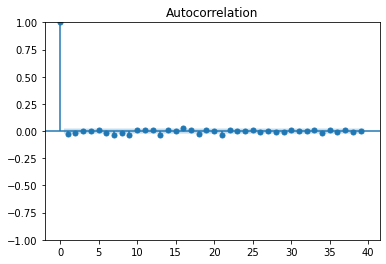

In [12]:
# Plot ACF with first_diff
plot_acf(df_filled['first_diff'])
plt.show()

## Modelling ARIMA model
Now that we have obtained our p, d, and q terms, we can now fit our data the ARIMA model with the terms. 

### Split data into train and test
In the research paper, the authors split the data into train and test. 

- Train data: January 3 2000 to May 16 2019
- Test data: May 17 2019 to July 1 2019

In [13]:
# Split your DataFrame into train using the dates
train = df_filled[:'2019-05-16']
train.head()

,Open,High,Low,Close,Adj Close,Volume,first_diff
Date,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-14.030029
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-55.799927
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,2.689941
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1.339966
2000-01-08,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.000000


In [14]:
# Split your DataFrame into test using the dates
test = df_filled['2019-05-17':]
test.head()

,Open,High,Low,Close,Adj Close,Volume,first_diff
Date,,,,,,,
2019-05-17,2858.600098,2885.479980,2854.229980,2859.530029,2859.530029,3257950000,2.800049
2019-05-18,2858.600098,2885.479980,2854.229980,2859.530029,2859.530029,3257950000,0.000000
2019-05-19,2858.600098,2885.479980,2854.229980,2859.530029,2859.530029,3257950000,0.000000
2019-05-20,2841.939941,2853.860107,2831.290039,2840.229980,2840.229980,3288870000,-16.660156
2019-05-21,2854.020020,2868.879883,2854.020020,2864.360107,2864.360107,3218700000,12.080078


## Predict and plot
Now that we've obtained the three terms, i.e. p=2, d=1, q=2, and split our data, we can now fit the data and subsequently plot our predictions.

In [15]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [16]:
# Declare an ARIMA model
mod = ARIMA(train['Open'], order=(2,1,2))

In [17]:
# Call .fit() on the variable and asign the results to the new variable
res = mod.fit()

In [18]:
forecast = res.forecast(steps = len(test))
forecast = pd.DataFrame(forecast)
forecast

,predicted_mean
2019-05-17,2854.854813
2019-05-18,2854.091354
2019-05-19,2854.214110
2019-05-20,2854.162859
2019-05-21,2854.177510
2019-05-22,2854.172766
2019-05-23,2854.174235
2019-05-24,2854.173773
2019-05-25,2854.173917
2019-05-26,2854.173872


In [19]:
# Assign the first item of the tuple into a variable
forecast_array = forecast["predicted_mean"]

In [20]:
# Create a Series of the forecast
forecast_series = pd.Series(forecast_array, index = test.index)
forecast_series

Date
2019-05-17    2854.854813
2019-05-18    2854.091354
2019-05-19    2854.214110
2019-05-20    2854.162859
2019-05-21    2854.177510
2019-05-22    2854.172766
2019-05-23    2854.174235
2019-05-24    2854.173773
2019-05-25    2854.173917
2019-05-26    2854.173872
2019-05-27    2854.173886
2019-05-28    2854.173882
2019-05-29    2854.173883
2019-05-30    2854.173883
2019-05-31    2854.173883
2019-06-01    2854.173883
2019-06-02    2854.173883
2019-06-03    2854.173883
2019-06-04    2854.173883
2019-06-05    2854.173883
2019-06-06    2854.173883
2019-06-07    2854.173883
2019-06-08    2854.173883
2019-06-09    2854.173883
2019-06-10    2854.173883
2019-06-11    2854.173883
2019-06-12    2854.173883
2019-06-13    2854.173883
2019-06-14    2854.173883
2019-06-15    2854.173883
2019-06-16    2854.173883
2019-06-17    2854.173883
2019-06-18    2854.173883
2019-06-19    2854.173883
2019-06-20    2854.173883
2019-06-21    2854.173883
2019-06-22    2854.173883
2019-06-23    2854.173883
2019-06

### Plot the forecast with the test data
We plot the forecast in the same plot as the test data.

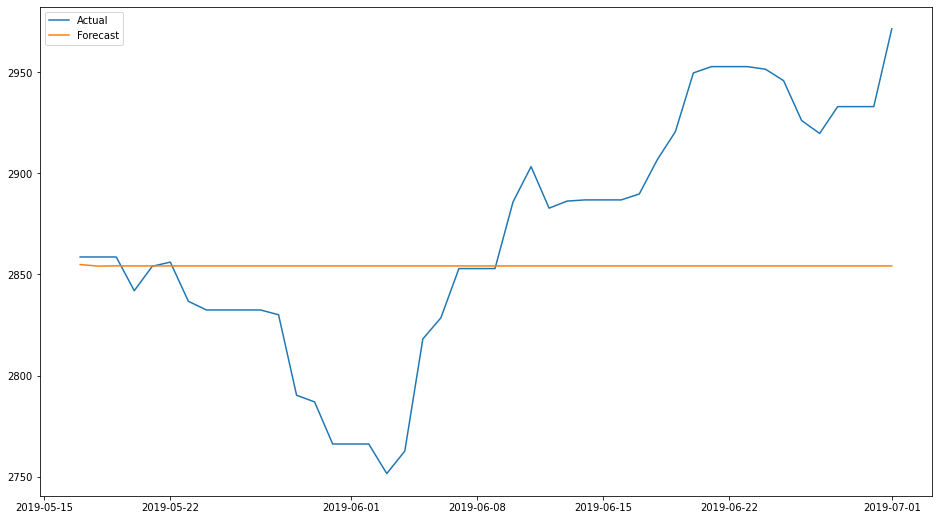

In [21]:
# Plot the forecast with test data
plt.figure(figsize = (16,9))
plt.plot(test['Open'])
plt.plot(forecast_series)
plt.legend(['Actual', 'Forecast'])

### End of Part II
In this Part, we performed ARIMA modelling to model the time series. The prediction ended up being a straight line because the data doesn't have strong seasonality. 

Next up in Part III, we will prepare the data for LSTM.